In [16]:
import os
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import multiprocessing
import itertools as it
from scipy.special import expit
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import warnings
warnings.simplefilter('ignore')

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()  # Nice plot aesthetic

# x -> u(x)

In [18]:
def u(x):
    return x**0.7

x = np.random.random(size=10)
y = u(x)

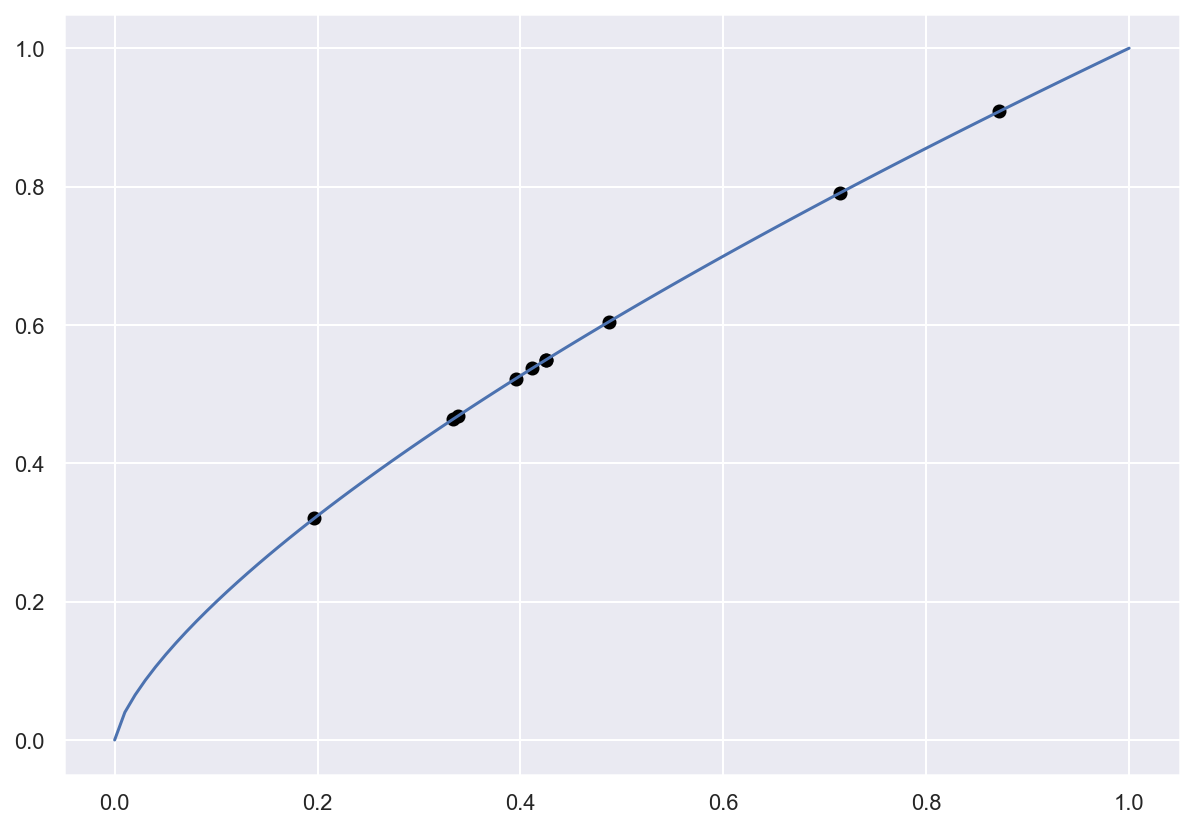

In [19]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(x, y, c="black")

x_plot = np.linspace(0, 1, 100)
ax.plot(x_plot, u(x_plot))

In [23]:
with pm.Model() as model:

    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 5)
    η = pm.HalfCauchy('η', 5)
    
    M = pm.gp.mean.Linear(coeffs=0)
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ) 
    
    σ = pm.HalfNormal('σ', 1)
    
    gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    gp.marginal_likelihood('y', X=x.reshape(-1, 1), y=y, noise=σ)
    

In [24]:
with model:
    gp_trace = pm.sample(1000, tune=1000, chains=2) # , tune=2000, cores=1, random_seed=43)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, η, ρ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8856911182735069, but should be close to 0.8. Try to increase the number of tuning steps.
There were 210 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


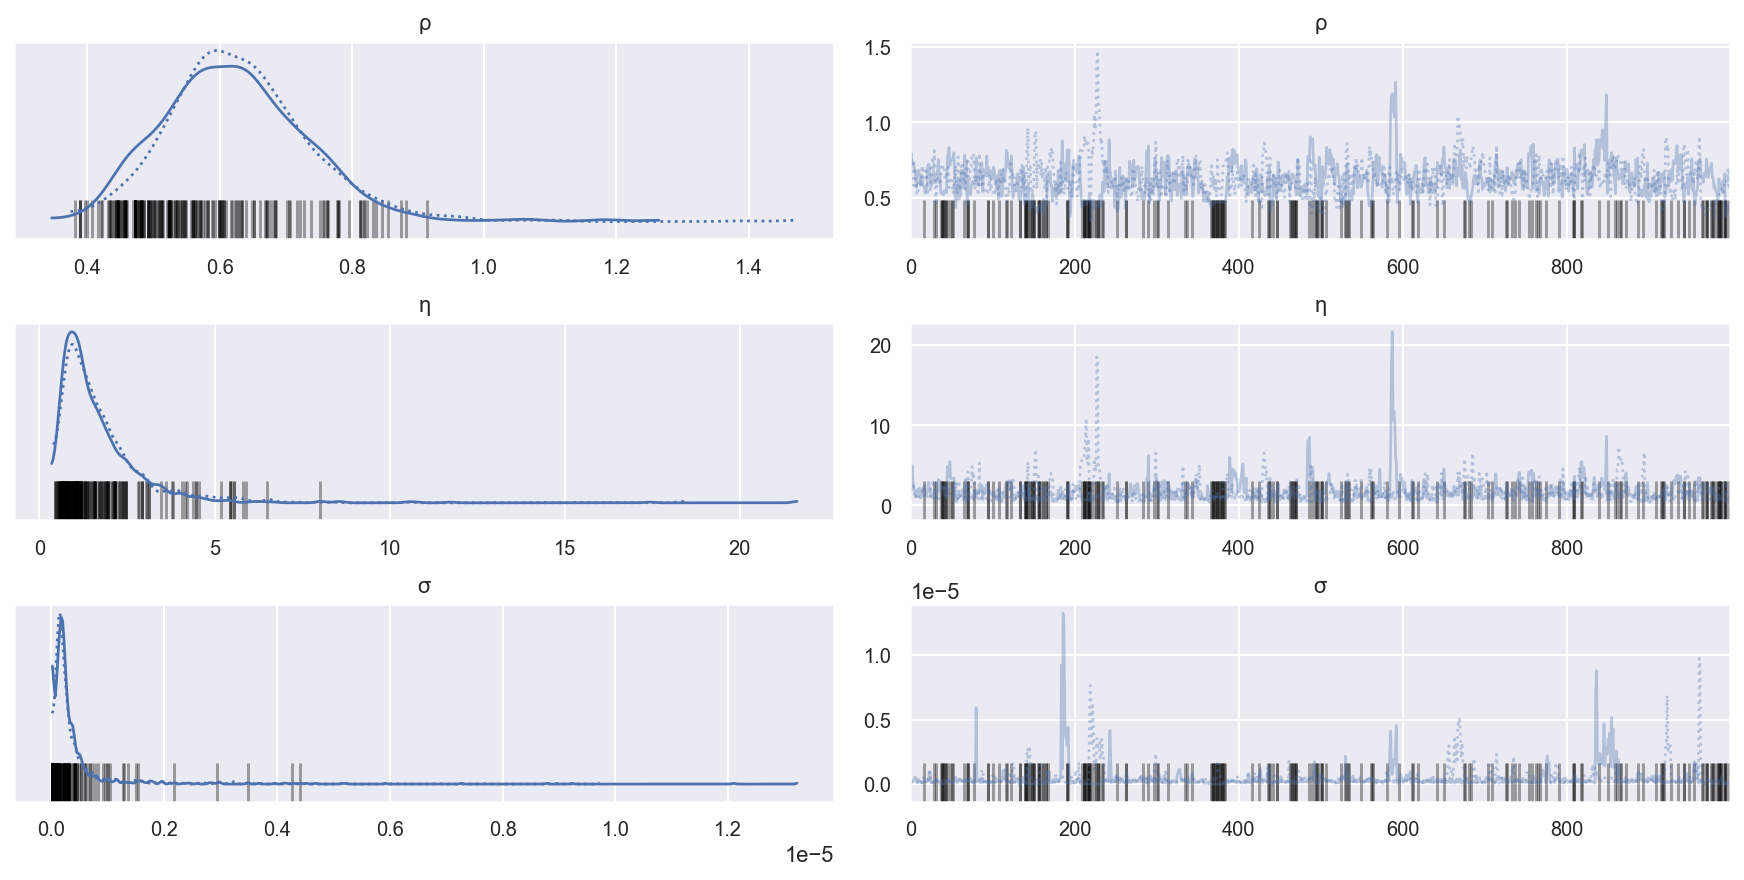

In [25]:
az.plot_trace(gp_trace, var_names=['ρ', 'η', 'σ']);

In [26]:
x_pred = np.linspace(0, 1, 100)
with model:
    y_pred = gp.conditional("y_pred", x_pred.reshape(-1, 1))

In [27]:
with model:
    samples = pm.sample_posterior_predictive(gp_trace, var_names=["y_pred"], samples=100, random_seed=42)

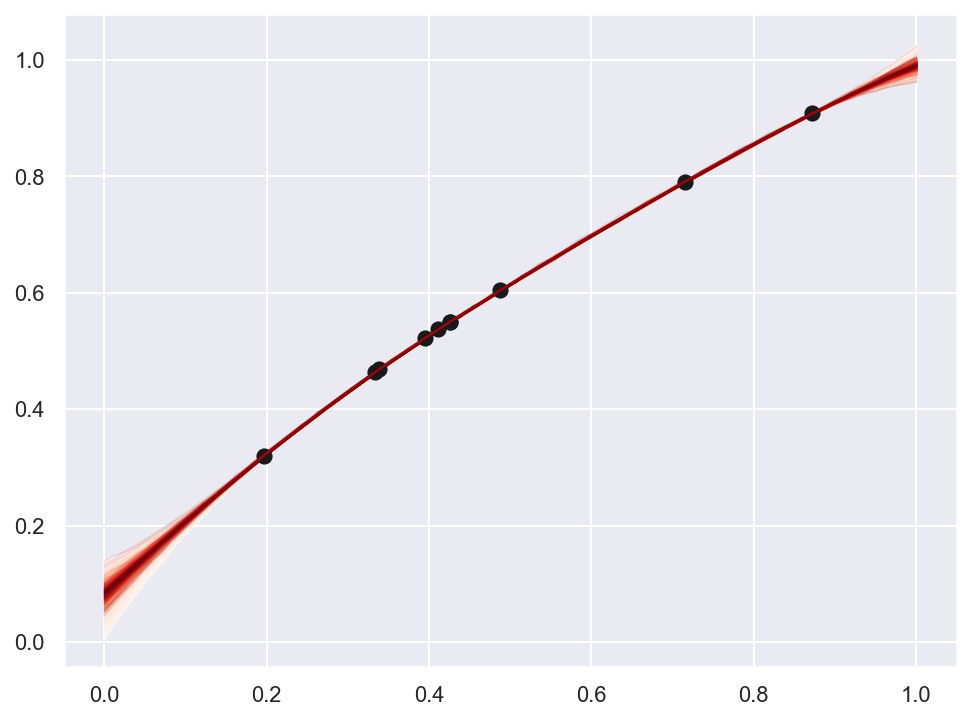

In [28]:
fig, ax = plt.subplots(figsize=(8,6))
pm.gp.util.plot_gp_dist(ax, samples['y_pred'], x_pred)
ax.scatter(x=x, y=y, c='k', s=50)

# x => u(x) => choice

In [38]:
def u(x):
    return np.sign(x)*np.abs(x)**0.7

def f(ux):
    return expit(3.33*ux)

x = np.random.uniform(-2, 2, size=100)
x.sort()
ux = u(x)
p_logit = 1/(1+np.exp(-3.33*ux))
y = p_logit > np.random.random(len(x))

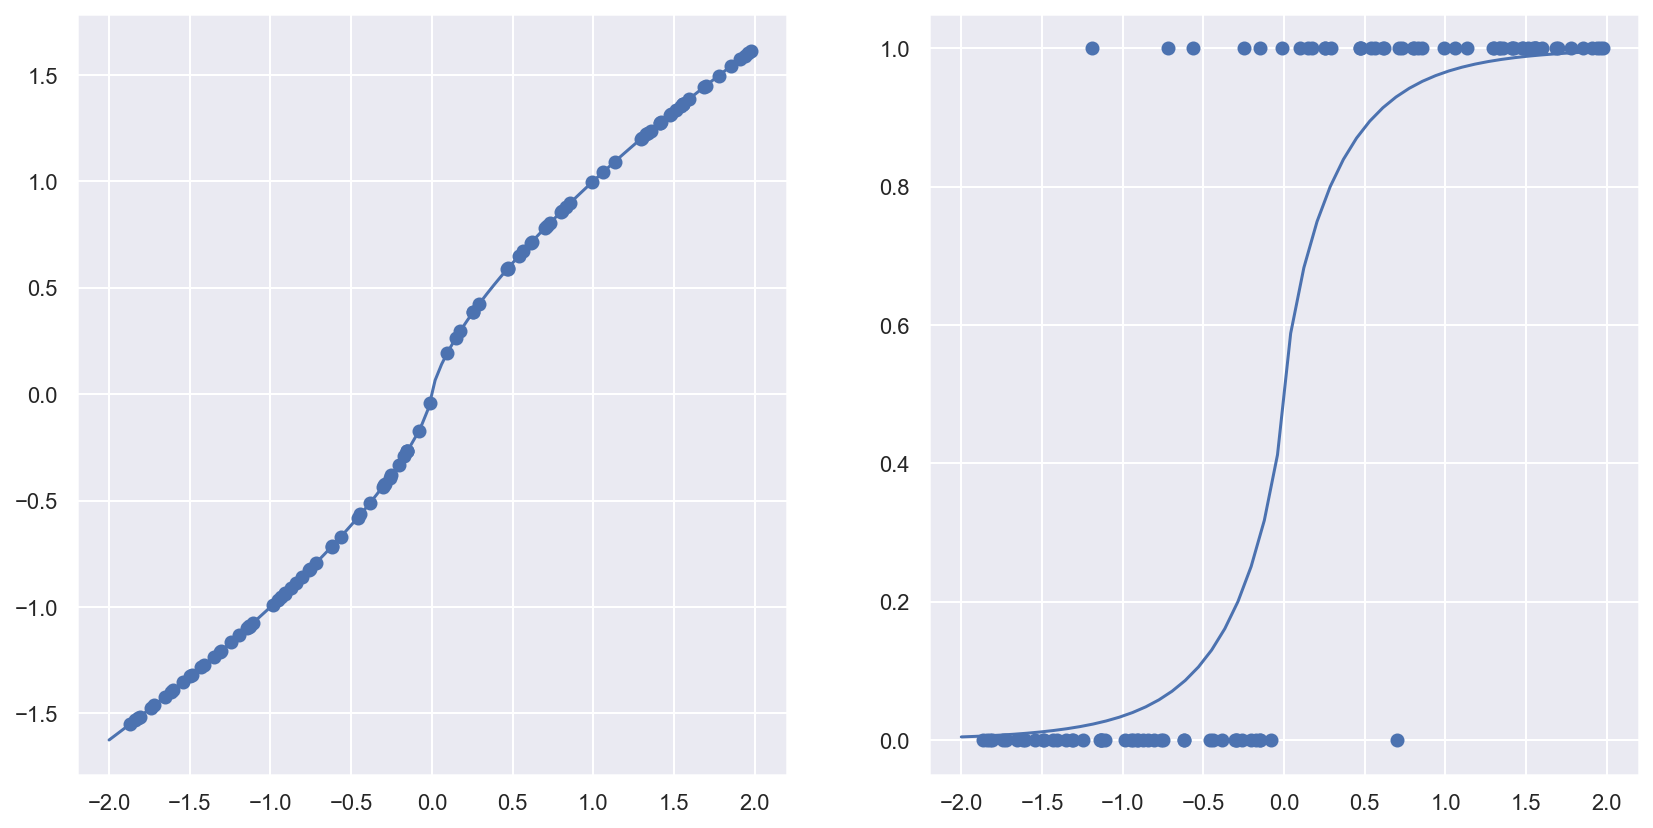

In [39]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 7))

x_plot = np.linspace(-2, 2, 100)

ax = axes[0]
ax.scatter(x, ux)
ax.plot(x_plot, u(x_plot))

ax = axes[1]
ax.scatter(x, y)
x_plot = np.linspace(-2, 2, )
ax.plot(x_plot, f(u(x_plot)))

In [33]:
with pm.Model() as model:
    
    ρ = pm.Normal('ρ', 1)
    η = pm.Normal('η', 1)
    
    K = η**2 * pm.gp.cov.ExpQuad(1, ρ)
    gp = pm.gp.Latent(cov_func=K)
    
    f = gp.prior('f', X=x.reshape(-1, 1))
    p = pm.Deterministic('p', pm.math.invlogit(3.33*f))
    y_ = pm.Bernoulli('y', p=p, observed=y)

In [34]:
with model:
    trace = pm.sample(1000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f_rotated_, η, ρ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 111 seconds.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


array([<AxesSubplot:title={'center':'ρ'}>,
       <AxesSubplot:title={'center':'η'}>], dtype=object)

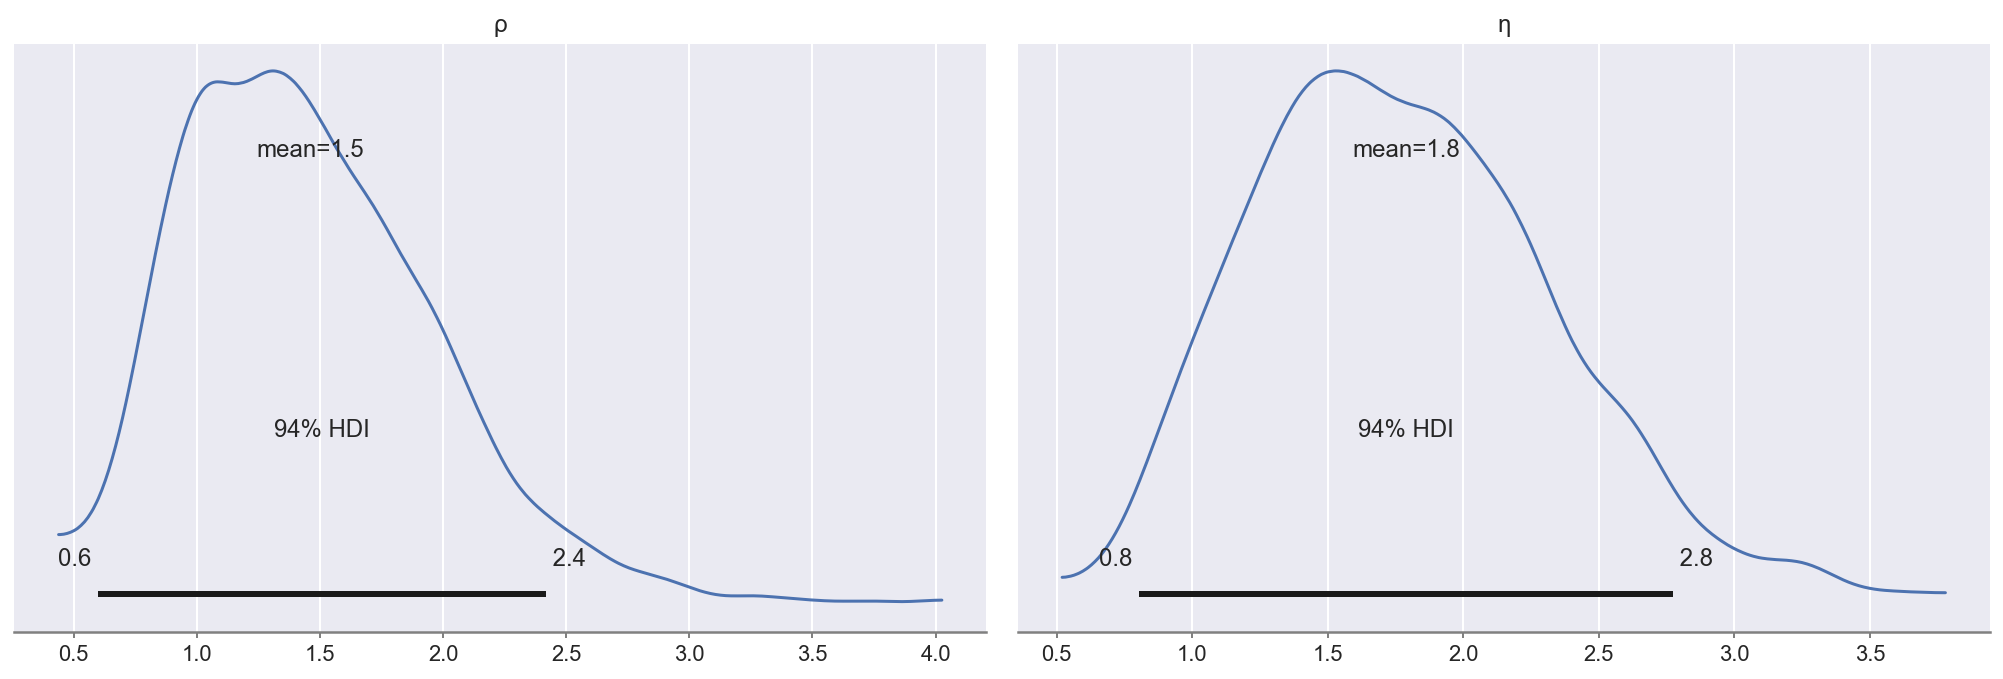

In [35]:
az.plot_posterior(trace, var_names=['ρ', 'η'])

In [36]:
with model:
    y_pred = pm.sample_posterior_predictive(trace, var_names=["f", "p"], samples=1000)

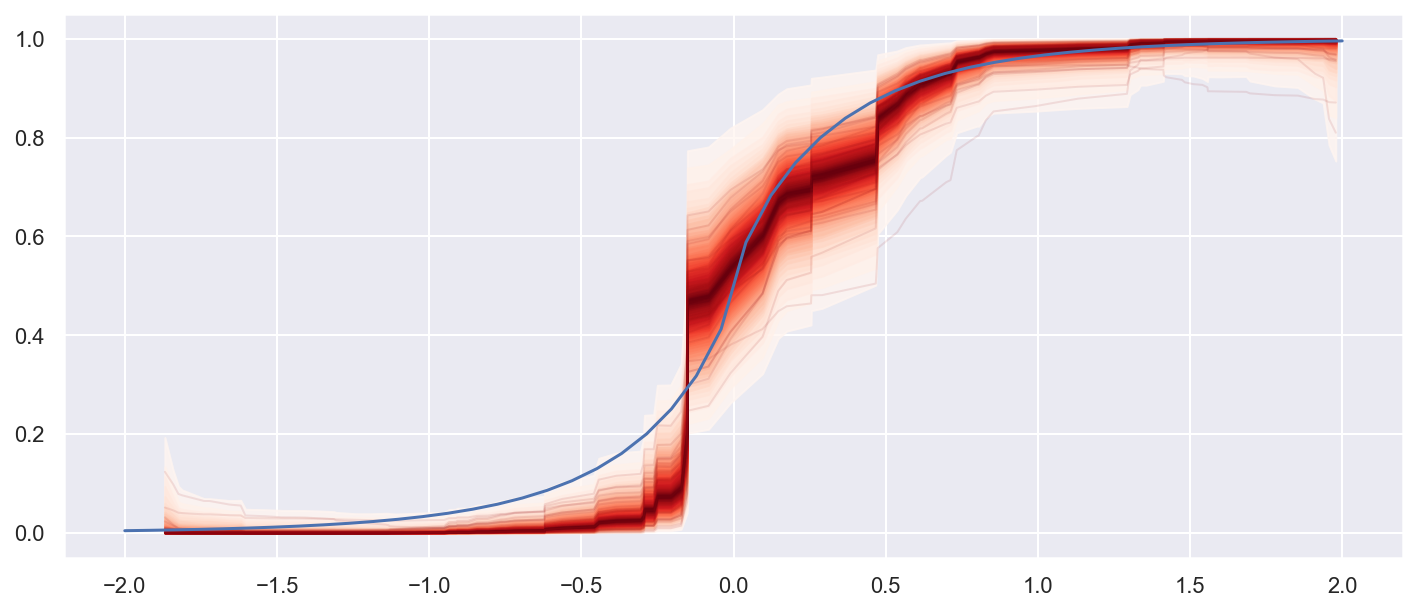

In [42]:
fig, ax = plt.subplots(figsize=(12,5))

pm.gp.util.plot_gp_dist(ax, expit(3.33*y_pred["f"]), x)
ax.plot(x_plot, f(u(x_plot)))

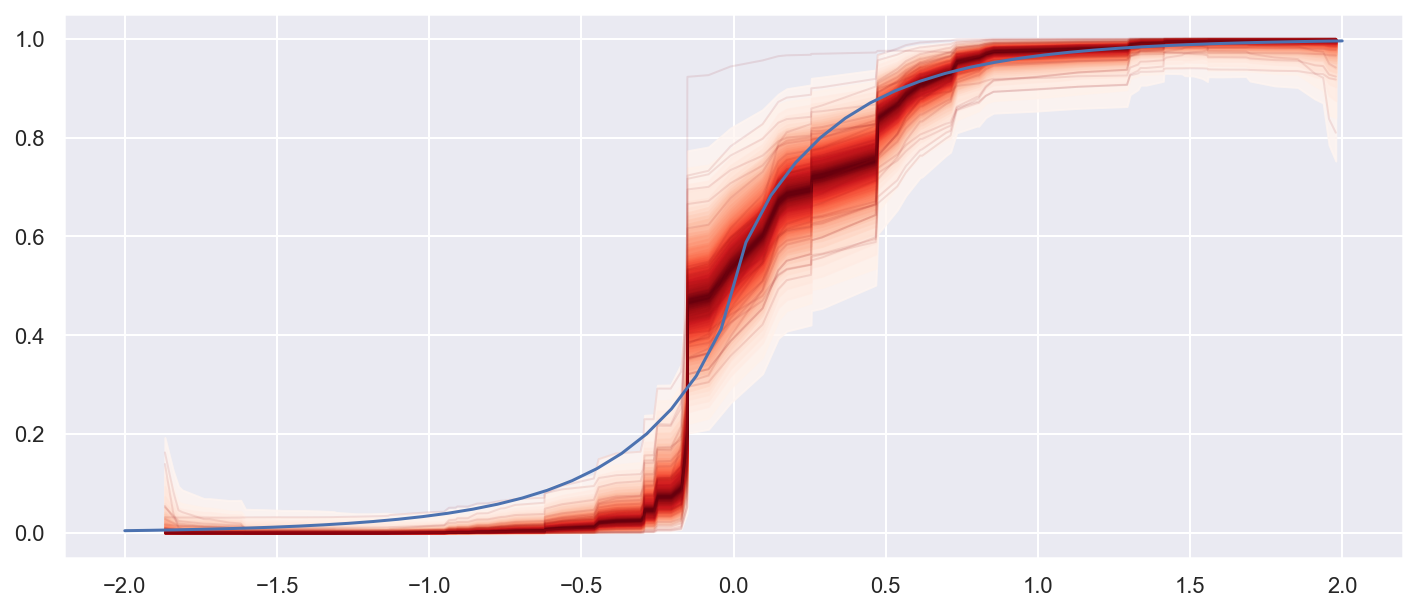

In [44]:
fig, ax = plt.subplots(figsize=(12,5))

pm.gp.util.plot_gp_dist(ax, y_pred["p"], x)
ax.plot(x_plot, f(u(x_plot)))

(-2.0, 2.0)

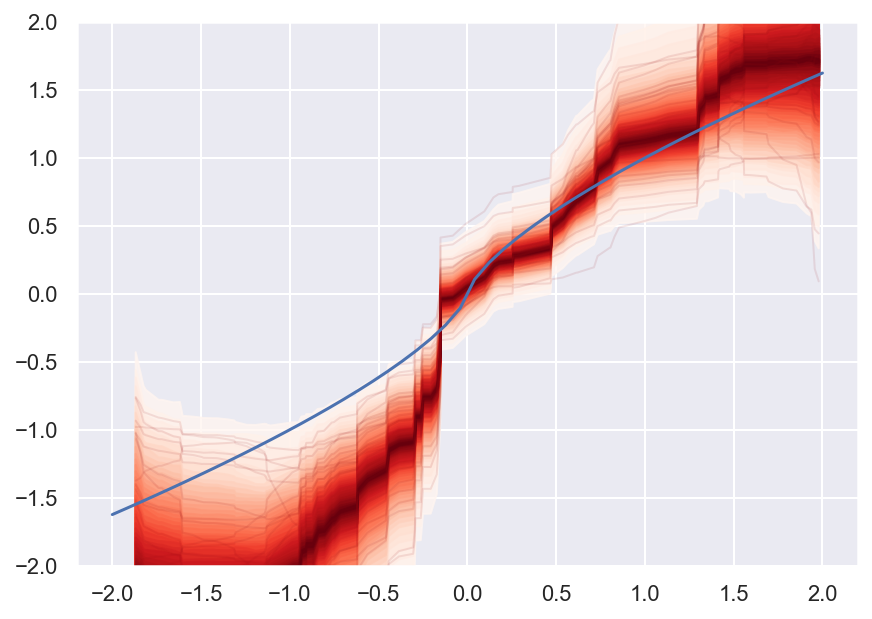

In [46]:
fig, ax = plt.subplots(figsize=(7,5))

pm.gp.util.plot_gp_dist(ax, y_pred["f"], x)
ax.plot(x_plot, u(x_plot))

ax.set_ylim(-2, 2)